<a href="https://colab.research.google.com/github/rajShaswat005/landslide-detection-unet/blob/main/Land_slide_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet torch torchvision torchaudio scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 325.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 421.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 521.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 268.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 396.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 352.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 690.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 479.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 570.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 328.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 394.2 kB/s eta 0:00:00


In [ ]:
import torch, torchvision
from torch import nn, optim
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np, os, random, shutil

print("PyTorch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


PyTorch: 2.6.0+cu124 | CUDA available: True


In [ ]:
from google.colab import files
files.upload()  # Upload the kaggle.json you downloaded


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rajshaswat","key":"1b3efa2fde9dea98d5a1f7b96afef6d9"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d tekbahadurkshetri/landslide4sense


Dataset URL: https://www.kaggle.com/datasets/tekbahadurkshetri/landslide4sense
License(s): other
 99% 2.83G/2.85G [01:05<00:00, 123MB/s]
100% 2.85G/2.85G [01:05<00:00, 46.5MB/s]


In [ ]:
import zipfile

zip_path = "/content/landslide4sense.zip"
extract_path = "/content/landslide4sense"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")


Dataset extracted successfully!


In [ ]:
import os

data_path = "/content/landslide4sense"
print(os.listdir(data_path))


['ValidData', 'TrainData', 'TestData']


In [ ]:
import os

train_path = "/content/landslide4sense/TrainData"
for item in os.listdir(train_path):
    print(item)


img
mask


In [ ]:
import os
from matplotlib import pyplot as plt
import cv2

# Paths
train_img_path = "/content/landslide4sense/TrainData/img"
train_mask_path = "/content/landslide4sense/TrainData/mask"

# Pick a sample image
img_name = os.listdir(train_img_path)[0]
img_path = os.path.join(train_img_path, img_name)
mask_path = os.path.join(train_mask_path, img_name)  # usually same name as image

# Read image and mask
img = cv2.imread(img_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # masks are usually grayscale

# Check if image loaded successfully
if img is None:
    print(f"Error loading image: {img_path}")
else:
    # Convert image to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Plot image and mask
    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.axis('off')

    plt.show()

Error loading image: /content/landslide4sense/TrainData/img/image_2473.h5


<KeysViewHDF5 ['img']>


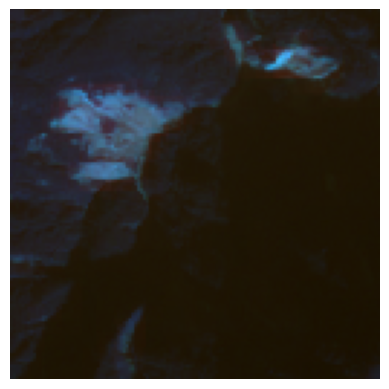

In [ ]:
import h5py
import numpy as np
from matplotlib import pyplot as plt

# Path to a sample .h5 file
h5_path = "/content/landslide4sense/TrainData/img/image_2473.h5"

# Open the .h5 file
with h5py.File(h5_path, 'r') as f:
    # Check the keys inside
    print(f.keys())

    # Load the dataset inside
    img = np.array(f['img'])

# Select the first 3 channels for RGB display
img_display = img[:, :, :3]

# Normalize the pixel values to the range [0, 1]
img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())

# Preview
plt.imshow(img_display)
plt.axis('off')
plt.show()

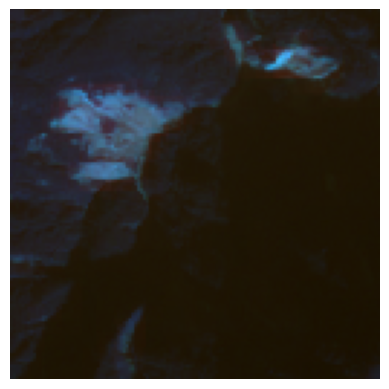

In [ ]:
import h5py
import numpy as np
from matplotlib import pyplot as plt

h5_path = "/content/landslide4sense/TrainData/img/image_2473.h5"

with h5py.File(h5_path, 'r') as f:
    img = np.array(f['img'])

# Select the first 3 channels for RGB display
img_display = img[:, :, :3]

# Correct normalization to 0–1
img_display = img_display - np.min(img_display)
img_display = img_display / np.max(img_display)

# Preview
plt.imshow(img_display)
plt.axis('off')
plt.show()


In [ ]:
import os

train_img_path = "/content/landslide4sense/TrainData/img"
train_mask_path = "/content/landslide4sense/TrainData/mask"

img_files = sorted(os.listdir(train_img_path))
mask_files = sorted(os.listdir(train_mask_path))

print(f"Number of images: {len(img_files)}")
print(f"Number of masks: {len(mask_files)}")

# Show first 10 filenames
print("Images:", img_files[:10])
print("Masks:", mask_files[:10])


Number of images: 3799
Number of masks: 3799
Images: ['image_1.h5', 'image_10.h5', 'image_100.h5', 'image_1000.h5', 'image_1001.h5', 'image_1002.h5', 'image_1003.h5', 'image_1004.h5', 'image_1005.h5', 'image_1006.h5']
Masks: ['mask_1.h5', 'mask_10.h5', 'mask_100.h5', 'mask_1000.h5', 'mask_1001.h5', 'mask_1002.h5', 'mask_1003.h5', 'mask_1004.h5', 'mask_1005.h5', 'mask_1006.h5']


In [ ]:
img_files = sorted(os.listdir(train_img_path))
mask_files = sorted(os.listdir(train_mask_path))

# Map image filename to corresponding mask filename
def get_mask_name(img_name):
    return "mask_" + img_name.split("_")[1]  # get the number part

# Example
img_name = "image_2473.h5"
mask_name = get_mask_name(img_name)
print(mask_name)  # outputs: mask_2473.h5


mask_2473.h5


In [ ]:
import h5py

mask_file = "/content/landslide4sense/TrainData/mask/mask_1.h5"

with h5py.File(mask_file, 'r') as f:
    print(f.keys())  # This will show the correct key


<KeysViewHDF5 ['mask']>


In [ ]:
with h5py.File(mask_file, 'r') as f:
    mask = np.array(f['mask'])  # use the correct key


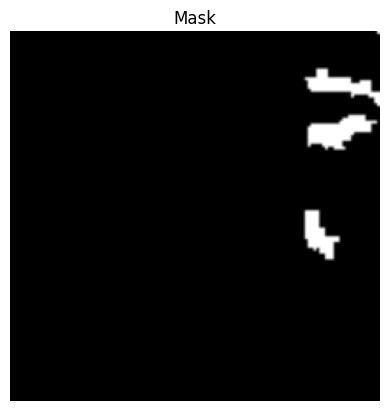

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Normalize mask to 0-1
mask = mask / np.max(mask)

# Resize mask to desired size (e.g., 256x256)
IMG_SIZE = 256
mask_resized = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

# Add channel dimension (needed for most segmentation models)
mask_resized = np.expand_dims(mask_resized, axis=-1)

# Preview the mask
plt.imshow(mask_resized[:, :, 0], cmap='gray')
plt.title("Mask")
plt.axis('off')
plt.show()


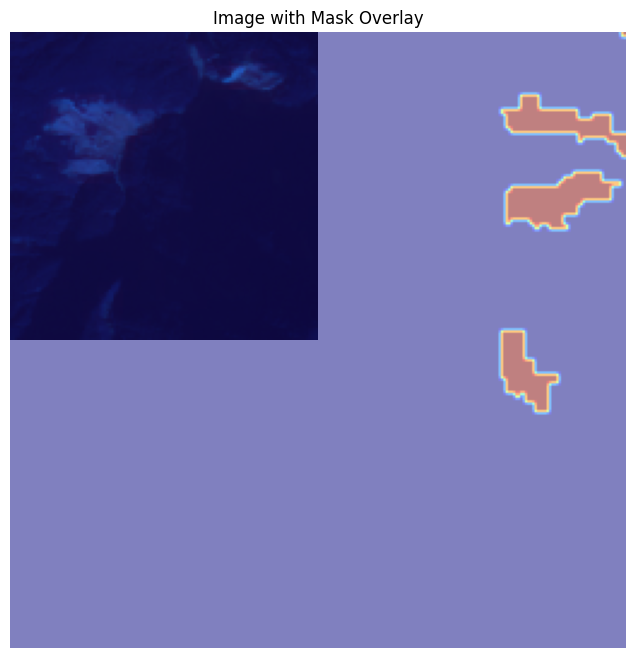

In [ ]:
import matplotlib.pyplot as plt

# img_display: your normalized RGB image
# mask_resized: preprocessed mask

plt.figure(figsize=(8,8))
plt.imshow(img_display)  # original image
plt.imshow(mask_resized[:, :, 0], cmap='jet', alpha=0.5)  # mask overlay
plt.title("Image with Mask Overlay")
plt.axis('off')
plt.show()


In [ ]:
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import cv2

# Define image size
IMG_SIZE = 256  # or the size your UNet expects

# Custom Dataset class
class LandslideDataset(Dataset):
    def __init__(self, image_files, mask_files):
        self.image_files = image_files
        self.mask_files = mask_files

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        with h5py.File(self.image_files[idx], 'r') as f:
            img = np.array(f['img'])
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0  # normalize
            img = np.transpose(img, (2, 0, 1))  # to channel-first for PyTorch

        # Load mask
        with h5py.File(self.mask_files[idx], 'r') as f:
            mask = np.array(f['mask'])
            mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
            mask = mask / (mask.max() + 1e-8)  # avoid divide by zero
            mask = np.expand_dims(mask, axis=0)  # channel-first

        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

# Example: load only first 50 images to avoid OOM
image_files = ['/content/landslide4sense/TrainData/images/image_{}.h5'.format(i) for i in range(50)]
mask_files  = ['/content/landslide4sense/TrainData/mask/mask_{}.h5'.format(i) for i in range(50)]

dataset = LandslideDataset(image_files, mask_files)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)  # small batch


In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.amp import GradScaler, autocast
import h5py
import cv2
import numpy as np
import os

# -------------------------
# Device
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------
# Dataset
# -------------------------
IMG_SIZE = 128  # Reduced size to save memory

class H5LandslideDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_size=IMG_SIZE):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_files = sorted(os.listdir(img_dir))
        self.img_size = img_size

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        mask_name = "mask_" + img_name.split("_")[1]

        # Load image
        with h5py.File(os.path.join(self.img_dir, img_name), 'r') as f:
            img = np.array(f['img'])[:, :, :3]
            img = cv2.resize(img, (self.img_size, self.img_size))
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)  # FIXED normalization
            img = np.transpose(img, (2, 0, 1))  # HWC -> CHW
            img = torch.tensor(img, dtype=torch.float32)

        # Load mask
        with h5py.File(os.path.join(self.mask_dir, mask_name), 'r') as f:
            mask = np.array(f['mask'])
            mask_max = mask.max()
            mask = mask / mask_max if mask_max > 0 else mask
            mask = cv2.resize(mask, (self.img_size, self.img_size))
            mask = np.expand_dims(mask, axis=0)  # 1 x H x W
            mask = torch.tensor(mask, dtype=torch.float32)

        return img, mask

# -------------------------
# UNet Model
# -------------------------
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)

        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)

        # Middle
        self.middle = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Output
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        pool1 = self.pool1(enc1)

        enc2 = self.encoder2(pool1)
        pool2 = self.pool2(enc2)

        mid = self.middle(pool2)

        up1 = self.upconv1(mid)
        dec1 = self.decoder1(torch.cat([up1, enc2], dim=1))

        up2 = self.upconv2(dec1)
        dec2 = self.decoder2(torch.cat([up2, enc1], dim=1))

        out = self.out_conv(dec2)
        return out

# -------------------------
# Prepare Data and Model
# -------------------------
train_dataset = H5LandslideDataset("/content/landslide4sense/TrainData/img",
                                   "/content/landslide4sense/TrainData/mask",
                                   img_size=IMG_SIZE)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # smaller batch to save memory

model = UNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scaler = GradScaler("cuda")  # fixed GradScaler warning

# -------------------------
# Training Loop
# -------------------------
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        with autocast("cuda"):
            outputs = model(imgs)
            loss = criterion(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Using device: cuda
Epoch [1/5], Loss: 0.0806
Epoch [2/5], Loss: 0.0624
Epoch [3/5], Loss: 0.0597
Epoch [4/5], Loss: 0.0591
Epoch [5/5], Loss: 0.0573


In [ ]:
torch.save(model.state_dict(), "unet_landslide.pth")
print("Model saved successfully!")


Model saved successfully!


In [ ]:
import torch
import torch.nn as nn

# Define the UNet model architecture
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)


        # Middle
        self.middle = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1), # 256 because of skip connection
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1), # 128 because of skip connection
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )


        # Output layer
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        print(f"Input shape: {x.shape}")
        # Encoder
        enc1 = self.encoder1(x)
        print(f"Encoder1 output shape: {enc1.shape}")
        pool1 = self.pool1(enc1)
        print(f"Pool1 output shape: {pool1.shape}")

        enc2 = self.encoder2(pool1)
        print(f"Encoder2 output shape: {enc2.shape}")
        pool2 = self.pool2(enc2)
        print(f"Pool2 output shape: {pool2.shape}")

        # Middle
        mid = self.middle(pool2)
        print(f"Middle output shape: {mid.shape}")

        # Decoder with skip connections
        up1 = self.upconv1(mid)
        print(f"Upconv1 output shape: {up1.shape}")
        dec1 = self.decoder1(torch.cat([up1, enc2], dim=1)) # Concatenate with skip connection from encoder2
        print(f"Decoder1 output shape: {dec1.shape}")

        up2 = self.upconv2(dec1)
        print(f"Upconv2 output shape: {up2.shape}")
        dec2 = self.decoder2(torch.cat([up2, enc1], dim=1)) # Concatenate with skip connection from encoder1
        print(f"Decoder2 output shape: {dec2.shape}")

        # Output layer
        out = self.out_conv(dec2)
        print(f"Output shape: {out.shape}")
        return out

In [ ]:
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=1).to(device)

# Take one sample from your dataset
# Make sure dataset paths are correct - the error indicates 'images' should be 'img'
train_img_path = "/content/landslide4sense/TrainData/img" # Corrected path
train_mask_path = "/content/landslide4sense/TrainData/mask" # Assuming mask path is correct
IMG_SIZE = 128 # Use the image size defined in the dataset

# Define the dataset (assuming H5LandslideDataset is defined)
train_dataset = H5LandslideDataset(train_img_path, train_mask_path, img_size=IMG_SIZE)

sample_img, sample_mask = train_dataset[0]
sample_img = sample_img.unsqueeze(0).to(device)  # add batch dimension

# Forward pass
with torch.no_grad():
    output = model(sample_img)

Input shape: torch.Size([1, 3, 128, 128])
Encoder1 output shape: torch.Size([1, 64, 128, 128])
Pool1 output shape: torch.Size([1, 64, 64, 64])
Encoder2 output shape: torch.Size([1, 128, 64, 64])
Pool2 output shape: torch.Size([1, 128, 32, 32])
Middle output shape: torch.Size([1, 256, 32, 32])
Upconv1 output shape: torch.Size([1, 128, 64, 64])
Decoder1 output shape: torch.Size([1, 128, 64, 64])
Upconv2 output shape: torch.Size([1, 64, 128, 128])
Decoder2 output shape: torch.Size([1, 64, 128, 128])
Output shape: torch.Size([1, 1, 128, 128])


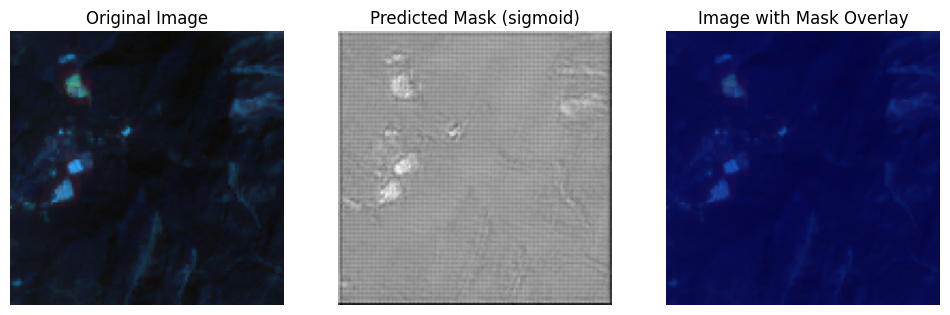

In [ ]:
import matplotlib.pyplot as plt
import torch

# Convert output to probability map using sigmoid
pred_mask = torch.sigmoid(output).squeeze(0).cpu().numpy()  # shape: 1 x H x W -> H x W

# Optional: create binary mask
binary_mask = (pred_mask > 0.5).astype(float)

# Convert sample image to CPU and transpose back to HWC for plotting
img_display = sample_img.squeeze(0).cpu().permute(1,2,0).numpy()

# Plot
plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
plt.imshow(img_display)  # original image
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(pred_mask.squeeze(), cmap='gray') # Squeeze to remove the channel dimension
plt.title("Predicted Mask (sigmoid)")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img_display)
plt.imshow(binary_mask.squeeze(), cmap='jet', alpha=0.5)  # overlay mask, squeeze binary_mask
plt.title("Image with Mask Overlay")
plt.axis('off')

plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib

def evaluate_model(model, dataset, device, threshold=0.5, num_samples=10):
    """
    Evaluates the UNet model on a given dataset.

    Args:
        model: Trained UNet model
        dataset: Dataset object (H5LandslideDataset)
        device: 'cuda' or 'cpu'
        threshold: Threshold to convert sigmoid outputs to binary masks
        num_samples: Number of samples to evaluate
    """
    model.eval()
    iou_scores = []
    dice_scores = []

    with torch.no_grad():
        for i in range(min(num_samples, len(dataset))):
            img, true_mask = dataset[i]
            img = img.unsqueeze(0).to(device)  # Add batch dim
            true_mask = true_mask.to(device)

            # Forward pass
            pred_mask = model(img)
            pred_mask = torch.sigmoid(pred_mask)  # Convert logits to probabilities

            # Binarize predictions
            pred_bin = (pred_mask > threshold).float()

            # Flatten masks
            pred_flat = pred_bin.view(-1)
            true_flat = true_mask.view(-1)

            # IoU
            intersection = (pred_flat * true_flat).sum()
            union = pred_flat.sum() + true_flat.sum() - intersection
            iou = (intersection / (union + 1e-8)).item()  # Add epsilon to avoid divide by zero
            iou_scores.append(iou)

            # Dice Score
            dice = (2 * intersection / (pred_flat.sum() + true_flat.sum() + 1e-8)).item()
            dice_scores.append(dice)

            # Optional: visualize first sample
            if i == 0:
                plt.figure(figsize=(12,4))

                plt.subplot(1,3,1)
                plt.imshow(img[0].cpu().permute(1,2,0))  # CHW -> HWC
                plt.title("Input Image")
                plt.axis('off')

                plt.subplot(1,3,2)
                plt.imshow(true_mask[0].squeeze(0).cpu(), cmap='gray') # Squeeze the channel dimension
                plt.title("Ground Truth Mask")
                plt.axis('off')

                plt.subplot(1,3,3)
                plt.imshow(pred_bin[0].squeeze(0).cpu(), cmap='gray') # Squeeze the channel dimension
                plt.title("Predicted Mask")
                plt.axis('off')

                plt.show()

    print(f"Average IoU: {np.mean(iou_scores):.4f}")
    print(f"Average Dice Score: {np.mean(dice_scores):.4f}")

Input shape: torch.Size([1, 3, 128, 128])
Encoder1 output shape: torch.Size([1, 64, 128, 128])
Pool1 output shape: torch.Size([1, 64, 64, 64])
Encoder2 output shape: torch.Size([1, 128, 64, 64])
Pool2 output shape: torch.Size([1, 128, 32, 32])
Middle output shape: torch.Size([1, 256, 32, 32])
Upconv1 output shape: torch.Size([1, 128, 64, 64])
Decoder1 output shape: torch.Size([1, 128, 64, 64])
Upconv2 output shape: torch.Size([1, 64, 128, 128])
Decoder2 output shape: torch.Size([1, 64, 128, 128])
Output shape: torch.Size([1, 1, 128, 128])


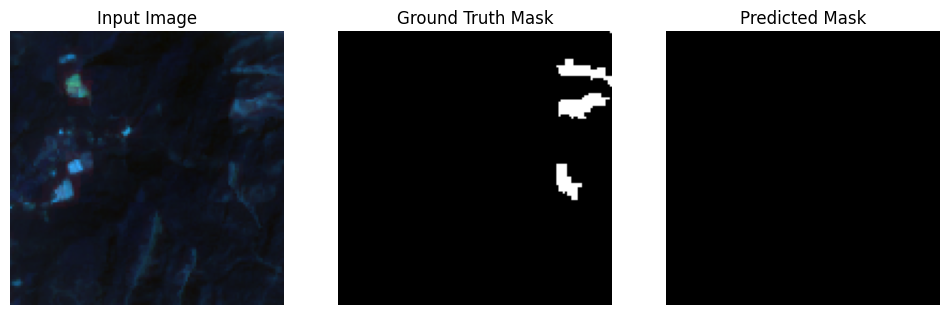

Input shape: torch.Size([1, 3, 128, 128])
Encoder1 output shape: torch.Size([1, 64, 128, 128])
Pool1 output shape: torch.Size([1, 64, 64, 64])
Encoder2 output shape: torch.Size([1, 128, 64, 64])
Pool2 output shape: torch.Size([1, 128, 32, 32])
Middle output shape: torch.Size([1, 256, 32, 32])
Upconv1 output shape: torch.Size([1, 128, 64, 64])
Decoder1 output shape: torch.Size([1, 128, 64, 64])
Upconv2 output shape: torch.Size([1, 64, 128, 128])
Decoder2 output shape: torch.Size([1, 64, 128, 128])
Output shape: torch.Size([1, 1, 128, 128])
Input shape: torch.Size([1, 3, 128, 128])
Encoder1 output shape: torch.Size([1, 64, 128, 128])
Pool1 output shape: torch.Size([1, 64, 64, 64])
Encoder2 output shape: torch.Size([1, 128, 64, 64])
Pool2 output shape: torch.Size([1, 128, 32, 32])
Middle output shape: torch.Size([1, 256, 32, 32])
Upconv1 output shape: torch.Size([1, 128, 64, 64])
Decoder1 output shape: torch.Size([1, 128, 64, 64])
Upconv2 output shape: torch.Size([1, 64, 128, 128])
Decode

In [ ]:
evaluate_model(model, train_dataset, device, threshold=0.5, num_samples=20)


Epoch [1/20], Loss: 0.9612
Epoch [2/20], Loss: 0.8061
Epoch [3/20], Loss: 0.7917
Epoch [4/20], Loss: 0.7837
Epoch [5/20], Loss: 0.7837
Epoch [6/20], Loss: 0.7695
Epoch [7/20], Loss: 0.7673
Epoch [8/20], Loss: 0.7668
Epoch [9/20], Loss: 0.7618
Epoch [10/20], Loss: 0.7698
Epoch [11/20], Loss: 0.7572
Epoch [12/20], Loss: 0.7561
Epoch [13/20], Loss: 0.7582
Epoch [14/20], Loss: 0.7548
Epoch [15/20], Loss: 0.7524
Epoch [16/20], Loss: 0.7471
Epoch [17/20], Loss: 0.7477
Epoch [18/20], Loss: 0.7461
Epoch [19/20], Loss: 0.7374
Epoch [20/20], Loss: 0.7369
Model saved as unet_landslide.pth
Average IoU: 0.1950
Average Dice Score: 0.2728


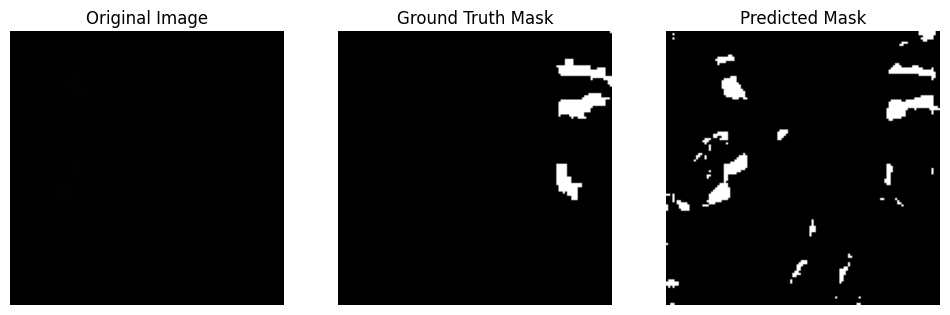

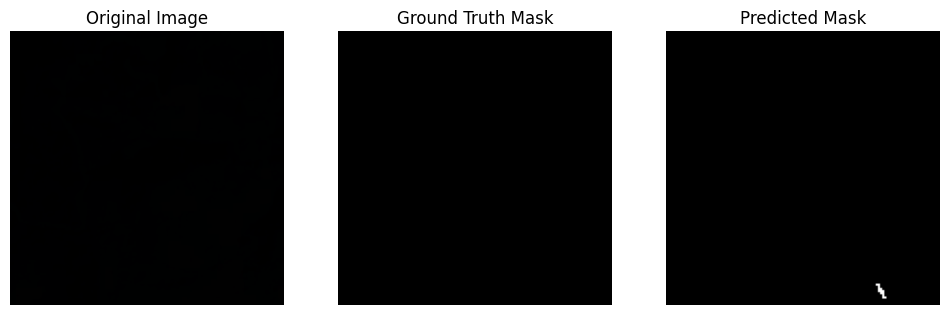

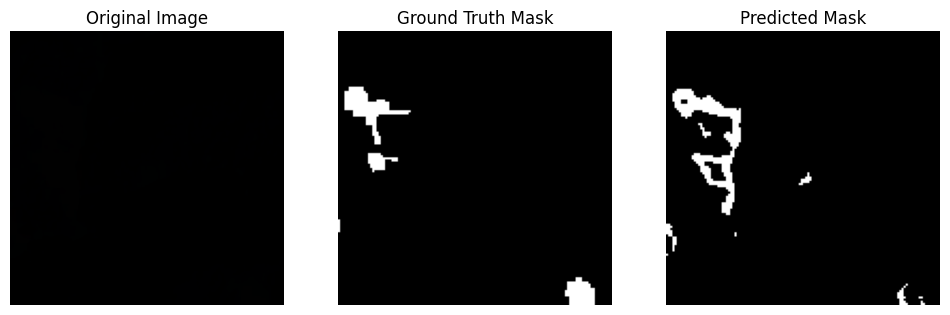

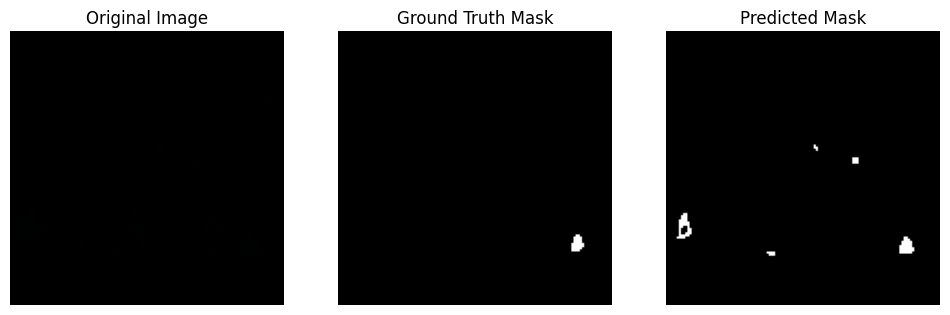

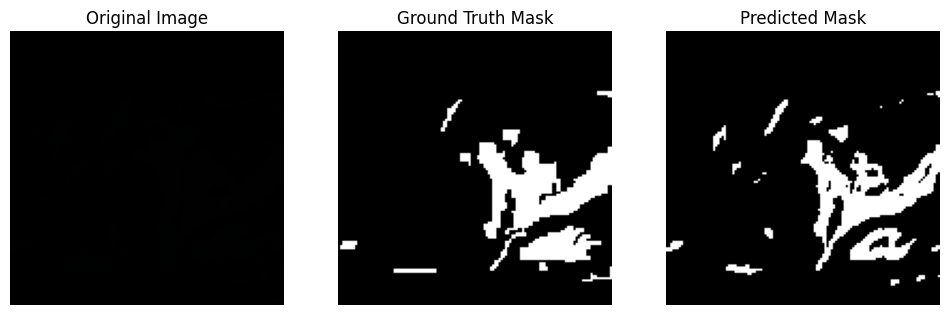

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
from torchvision import transforms

# -----------------------------
# 1. Dataset Class
# -----------------------------
class H5LandslideDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_size=128, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_files = sorted(os.listdir(img_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        # Load image
        with h5py.File(os.path.join(self.img_dir, self.img_files[idx]), 'r') as f:
            img = np.array(f['img'])
        img = cv2.resize(img[:, :, :3], (self.img_size, self.img_size))
        img = img / 255.0
        img = np.transpose(img, (2, 0, 1))  # channel-first

        # Load mask
        with h5py.File(os.path.join(self.mask_dir, self.mask_files[idx]), 'r') as f:
            mask = np.array(f['mask'])
        mask = cv2.resize(mask, (self.img_size, self.img_size))
        mask = mask / (mask.max() + 1e-8)
        mask = np.expand_dims(mask, axis=0)

        img_tensor = torch.tensor(img, dtype=torch.float32)
        mask_tensor = torch.tensor(mask, dtype=torch.float32)

        # Optional augmentation
        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, mask_tensor

# -----------------------------
# 2. UNet Model (already defined)
# -----------------------------
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2,2)
        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2,2)

        # Middle
        self.middle = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True)
        )

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True)
        )
        self.upconv2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True)
        )

        self.out_conv = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        pool1 = self.pool1(enc1)
        enc2 = self.encoder2(pool1)
        pool2 = self.pool2(enc2)
        mid = self.middle(pool2)
        up1 = self.upconv1(mid)
        dec1 = self.decoder1(torch.cat([up1, enc2], dim=1))
        up2 = self.upconv2(dec1)
        dec2 = self.decoder2(torch.cat([up2, enc1], dim=1))
        out = self.out_conv(dec2)
        return out

# -----------------------------
# 3. Loss Functions
# -----------------------------
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    return 1 - (2.*intersection + smooth) / (pred.sum() + target.sum() + smooth)

bce_loss = nn.BCEWithLogitsLoss()

# -----------------------------
# 4. Training Loop
# -----------------------------
def train_model(model, train_loader, val_loader=None, epochs=20, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = bce_loss(outputs, masks) + dice_loss(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

    # Save model
    torch.save(model.state_dict(), "unet_landslide.pth")
    print("Model saved as unet_landslide.pth")

# -----------------------------
# 5. Evaluation Function
# -----------------------------
def evaluate_model(model, dataset, batch_size=1):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    iou_scores, dice_scores = [], []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = torch.sigmoid(model(imgs))
            preds = (outputs > 0.5).float()

            # IoU
            intersection = (preds * masks).sum(dim=(1,2,3))
            union = ((preds + masks) - (preds * masks)).sum(dim=(1,2,3))
            iou = (intersection / (union + 1e-6)).mean().item()
            dice = (2*intersection / (preds.sum(dim=(1,2,3)) + masks.sum(dim=(1,2,3)) + 1e-6)).mean().item()

            iou_scores.append(iou)
            dice_scores.append(dice)

    print(f"Average IoU: {np.mean(iou_scores):.4f}")
    print(f"Average Dice Score: {np.mean(dice_scores):.4f}")

# -----------------------------
# 6. Visualization
# -----------------------------
def visualize_prediction(model, dataset, idx=0):
    img, mask = dataset[idx]
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img_input = img.unsqueeze(0).to(device)
    with torch.no_grad():
        output = torch.sigmoid(model(img_input))[0,0].cpu().numpy()
        pred_mask = (output > 0.5).astype(np.float32)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(np.transpose(img.numpy(), (1,2,0)))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(mask[0].numpy(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')
    plt.show()

# -----------------------------
# 7. Example Usage
# -----------------------------
# Dataset paths
train_img_path = "/content/landslide4sense/TrainData/img"
train_mask_path = "/content/landslide4sense/TrainData/mask"

IMG_SIZE = 128
batch_size = 4

train_dataset = H5LandslideDataset(train_img_path, train_mask_path, img_size=IMG_SIZE)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model
model = UNet(in_channels=3, out_channels=1)

# Train
train_model(model, train_loader, epochs=20, lr=1e-3)

# Evaluate
evaluate_model(model, train_dataset)

# Visualize first 5 predictions
for i in range(5):
    visualize_prediction(model, train_dataset, idx=i)
